# Probabilistic Modeling Different Keras Backends (pytorch)

Currently (November 2024) we have to create a wrapper object making the distribution.

In [1]:
import numpy as np
np.random.seed(42)
x_train = np.random.uniform(-10, 10, (1000, 1)).astype(np.float32)
y_train = (2 * x_train + np.random.normal(0, np.abs(x_train) + 1, (1000, 1))).astype(np.float32)

In [ ]:
import os
# Set Keras backend to PyTorch
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" #Needed on MAC to avoid MPS error (22 Nov 2024)
os.environ["KERAS_BACKEND"] = "torch" # Before importing Keras!

import numpy as np
from keras import layers, Input, Model
from keras.optimizers import Adam
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import time


# Print versions
import keras
print(f"Keras version: {keras.__version__}")
print(f"Backend: {keras.backend.backend()}")
print(f"torch version: {torch.__version__}")

Keras version: 3.6.0
Backend: torch
torch version: 2.1.2


Currently there is no `DistributionLayer` in Keras 3.0, as there is in tf_keras (see [pm_tfkeras.ipynb](https://github.com/tensorchiefs/dl_keras3/blob/main/notebooks/probabilistic_modelling/pm_tfkeras.ipynb)). Therefore we create a wrapper object that takes the output of the NN and returns a numpyro distribution object.  

In [3]:
# Wrapper function to convert model output to a PyTorch Normal distribution
@staticmethod
def output_to_gaussian_distribution(output):
    mean = output[:, :1]
    log_variance = output[:, 1:]
    scale = torch.exp(log_variance)  # Ensure positive scale
    return Normal(loc=mean, scale=scale)

In [4]:
# Define the model
inputs = Input(shape=(1,))
hidden = layers.Dense(10, activation="relu")(inputs)
outputs = layers.Dense(2)(hidden)  # Outputs mean and log(variance)
model = Model(inputs=inputs, outputs=outputs)

# Custom Negative Log-Likelihood Loss
def negative_log_likelihood(y_true, output):
    dist = output_to_gaussian_distribution(output)
    return -dist.log_prob(torch.tensor(y_true)).mean()

# Compile the model
model.compile(optimizer="adam", loss=negative_log_likelihood)

print(F'Prediction on untrained model (5 Datapoints)\n {model.predict(x_train[0:5])}')

# Train the model and measure timing
start_time = time.time()
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
torch_training_time = time.time() - start_time

print(f"Torch Training Time: {torch_training_time:.2f} seconds")

# Predict the distribution
x_test = np.linspace(-10, 10, 100).reshape(-1, 1)
dist = output_to_gaussian_distribution(model(x_test))

# Use the distribution
samples = dist.sample((5,))  # Draw 5 samples
print("Torch Samples:", samples.shape)

log_p = dist.log_prob(torch.tensor(0.1)).cpu().detach().numpy()
log_p.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction on untrained model (5 Datapoints)
 [[-2.0419161  -0.02838228]
 [-0.39551598 -1.988627  ]
 [-0.20358191 -1.023596  ]
 [-0.08657593 -0.43529773]
 [-5.598452   -0.07781751]]


/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_64045/329221948.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -dist.log_prob(torch.tensor(y_true)).mean()
/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/keras/src/backend/torch/optimizers/torch_adam.py:35: UserWarning: The operator 'aten::_foreach_mul_.Scalar' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch._foreach_mul_(m_list, self.beta_1)


Torch Training Time: 61.48 seconds
Torch Samples: torch.Size([5, 100, 1])


(100, 1)

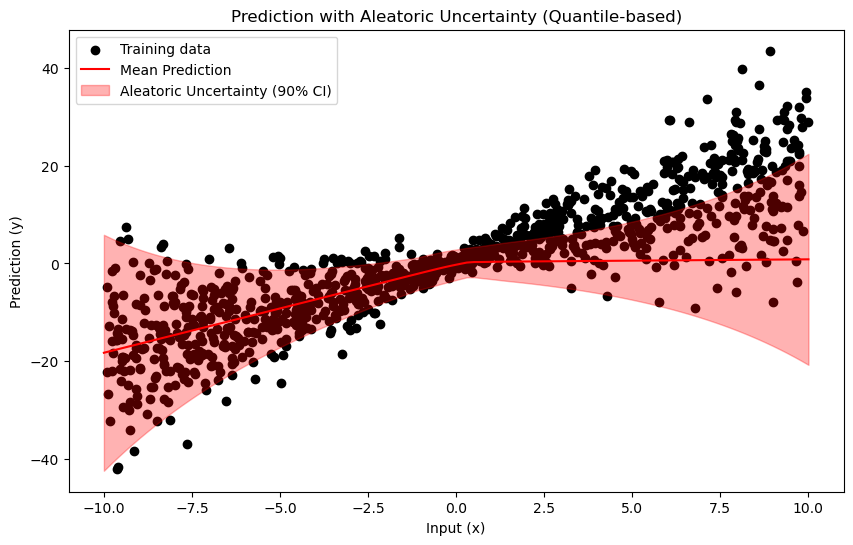

In [6]:
# Berechne Quantile direkt aus der Verteilung
# Compute 5% and 95% quantiles directly
quantile_5 = dist.icdf(torch.tensor(0.05)).cpu().detach().numpy()
quantile_95 = dist.icdf(torch.tensor(0.95)).cpu().detach().numpy()
mean = dist.mean.cpu().detach().numpy().squeeze()
# Visualisierung
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(x_train, y_train, color="black", label="Training data")
plt.plot(x_test, mean, color="red", label="Mean Prediction")
plt.fill_between(
    x_test.ravel(),
    quantile_5.squeeze(),  # 5%-Quantil
    quantile_95.squeeze(),  # 95%-Quantil
    color="red",
    alpha=0.3,
    label="Aleatoric Uncertainty (90% CI)"
)
plt.legend()
plt.xlabel("Input (x)")
plt.ylabel("Prediction (y)")
plt.title("Prediction with Aleatoric Uncertainty (Quantile-based)")
plt.show()